# Gestión de Topología SDN Multi-dispositivo con gRPC

Este cuaderno simula una topología de red más compleja (core switch, access switch, router, firewall) y demuestra la gestión centralizada a través de **gRPC**.

Incluye configuración de VLANs, monitoreo concurrente de métricas y gestión de fallos.

---

### Metodo 1 - Configuración Manual (Recomendado para un entorno limpio)

1. **Crea un entorno virtual** y asegúrate de haber instalado las dependencias desde el archivo `requirements.txt` ubicado en la raíz del proyecto:

   ```bash
   pip install -r ../requirements.txt  # Si ejecutas desde src
   # o, si copiaste requirements.txt a src/
   pip install -r requirements.txt

2. **Genera los stubs de gRPC** si los archivos `sdn_northbound_pb2.py` y `sdn_northbound_pb2_grpc.py` no están presentes en la carpeta `src/`.

   Puedes hacerlo ejecutando la siguiente celda en tu cuaderno o directamente desde la terminal (asegúrate de estar ubicado dentro de la carpeta `src/`):

   ```bash
   python -m grpc_tools.protoc -I. --python_out=. --grpc_python_out=. sdn_northbound.proto

### Metodo 2 - Ejecución Directa desde los Jupyter Notebooks (Menos recomendado para producción)*ç

1. **Instalar dependencias** (si no están ya).
   ```bash
   pip install grpcio-tools matplotlib numpy seaborn

2. **Crear el archivo .proto**
   ```bash
   with open('sdn_northbound.proto', 'w') as f:
      f.write(""" ...contenido del proto... """)

3. **Generar los stubs gRPC**
   ```bash
   !python -m grpc_tools.protoc -I. --python_out=. --grpc_python_out=. sdn_northbound.proto

**Nota**: todos estos pasos ya estan en los Notebooks, solo hace falta descomentarlos.

🟢 Servidor iniciado en puerto 50051
📝 Configurando VLAN 100 en switch1
Config Response: VLAN 100 creada en switch1
⏱️ 12:15:18 | CPU: 74.9000015258789% | Tráfico: 248,331 bytes
⏱️ 12:15:19 | CPU: 73.98999786376953% | Tráfico: 250,944 bytes
⏱️ 12:15:20 | CPU: 75.55000305175781% | Tráfico: 245,271 bytes
⏱️ 12:15:21 | CPU: 79.5% | Tráfico: 261,561 bytes
⏱️ 12:15:22 | CPU: 77.80000305175781% | Tráfico: 281,799 bytes
⏱️ 12:15:23 | CPU: 75.05000305175781% | Tráfico: 248,586 bytes
⏱️ 12:15:24 | CPU: 74.95999908447266% | Tráfico: 242,965 bytes
⏱️ 12:15:25 | CPU: 74.45999908447266% | Tráfico: 244,614 bytes
⏱️ 12:15:26 | CPU: 77.16999816894531% | Tráfico: 242,878 bytes
⏱️ 12:15:27 | CPU: 83.5% | Tráfico: 251,152 bytes
⏱️ 12:15:28 | CPU: 80.08000183105469% | Tráfico: 247,907 bytes
⏱️ 12:15:29 | CPU: 79.0999984741211% | Tráfico: 243,460 bytes
⏱️ 12:15:30 | CPU: 76.73999786376953% | Tráfico: 243,981 bytes
⏱️ 12:15:31 | CPU: 81.75% | Tráfico: 312,427 bytes
⏱️ 12:15:32 | CPU: 80.33000183105469% | Trá

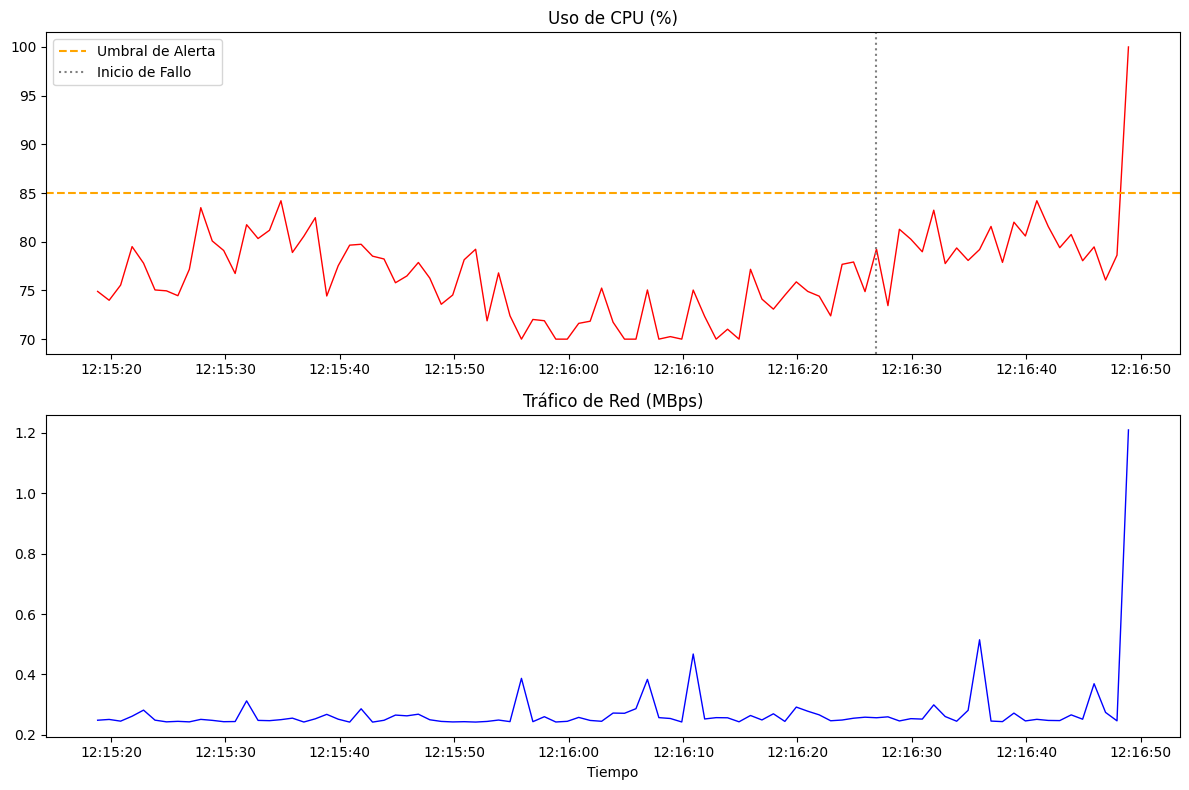

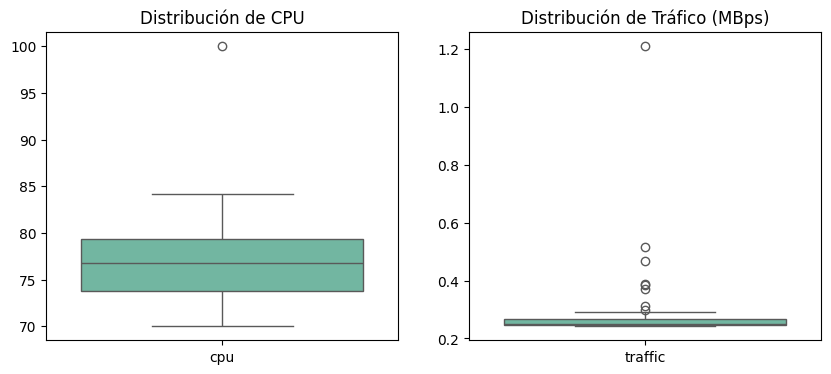

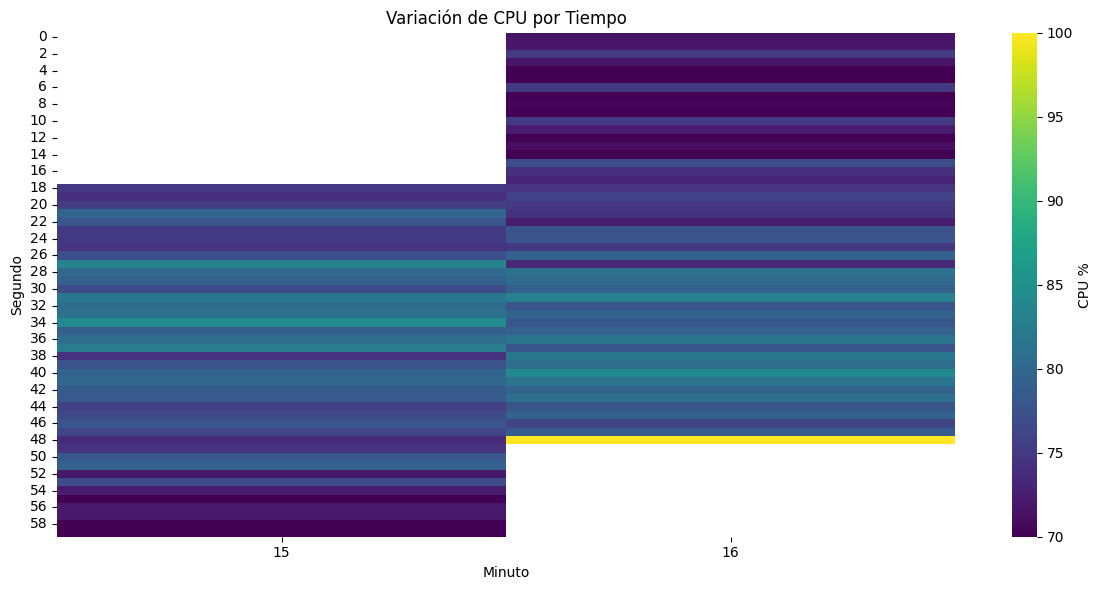


🔴 Servidor detenido


In [2]:
# P1. Instalar dependencias
#!pip install grpcio-tools matplotlib numpy seaborn

# P2. Crear archivo .proto
#with open('sdn_northbound.proto', 'w') as f:
#    f.write("""
#syntax = "proto3";

#service SDNNorthbound {
#  rpc UpdateVlan(VlanConfig) returns (ConfigResponse) {}
#  rpc StreamMetrics(DeviceQuery) returns (stream MetricData) {}
#  rpc ReportFault(FaultNotification) returns (FaultAck) {}
#}

#message VlanConfig {
#  string device_id = 1;
#  uint32 vlan_id = 2;
#  string name = 3;
#}

#message ConfigResponse {
#  bool success = 1;
#  string message = 2;
#}

#message DeviceQuery {
#  string device_id = 1;
#  uint32 interval = 2;
#}

#message MetricData {
#  float cpu = 1;
#  uint64 traffic = 2;
#  string timestamp = 3;
#}

#message FaultNotification {
#  string device_id = 1;
#  string description = 2;
#}

#message FaultAck {
#  bool received = 1;
#  string timestamp = 2;
#}
#""")

# P3. Generar código gRPC
#!python -m grpc_tools.protoc -I. --python_out=. --grpc_python_out=. sdn_northbound.proto

# Importar dependencias
import grpc
from concurrent import futures
import time
import math
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sdn_northbound_pb2 import *
from sdn_northbound_pb2_grpc import *
import threading

# ================== Servidor Ajustado ==================
class NorthboundServicer(SDNNorthboundServicer):
    def __init__(self):
        self.fault_triggered = False
        self.simulation_duration = 120  # 2 minutos
        self.base_traffic = 242000  # 242 KB/s (720p YouTube)

    def UpdateVlan(self, request, context):
        print(f"📝 Configurando VLAN {request.vlan_id} en {request.device_id}")
        return ConfigResponse(
            success=True,
            message=f"VLAN {request.vlan_id} creada en {request.device_id}"
        )

    def StreamMetrics(self, request, context):
        start_time = time.time()

        while not self.fault_triggered:
            elapsed = time.time() - start_time

            # Fase 1: Comportamiento normal (70-80% CPU)
            if elapsed < 90:
                # Variación de tráfico controlada
                traffic = self.base_traffic * (1 + 0.1 * np.random.pareto(2))
                # CPU base + variación sinusoidal + ruido
                cpu = 75 + 5 * math.sin(elapsed/10) + np.random.normal(0, 2)

            # Fase 2: Escalado a fallo (últimos 30s)
            else:
                traffic = self.base_traffic * 5  # Aumento brusco
                cpu = 100.0
                self.fault_triggered = True

            yield MetricData(
                cpu=np.clip(round(float(cpu), 2), 70, 100),
                traffic=int(traffic),
                timestamp=datetime.now().isoformat()
            )
            time.sleep(request.interval)

        self.ReportFaultInternal("Critical CPU Overload")

    def ReportFault(self, request, context):
        print(f"🚨 Fallo reportado: {request.description}")
        return FaultAck(
            received=True,
            timestamp=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        )

    def ReportFaultInternal(self, description):
        print(f"🔥 [Auto-detectado] {description}")

def start_server():
    server = grpc.server(futures.ThreadPoolExecutor(max_workers=10))
    add_SDNNorthboundServicer_to_server(NorthboundServicer(), server)
    server.add_insecure_port('[::]:50051')
    server.start()
    print("🟢 Servidor iniciado en puerto 50051")
    return server

# ================== Visualización Mejorada ==================
def analyze_traffic(metrics):
    df = pd.DataFrame(metrics)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # 1. Gráficos de Líneas Separados
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    # CPU
    ax[0].plot(df['timestamp'], df['cpu'], 'r-', linewidth=1)
    ax[0].set_title('Uso de CPU (%)', fontsize=12)
    ax[0].axhline(85, color='orange', linestyle='--', label='Umbral de Alerta')
    ax[0].axvline(df['timestamp'].iloc[int(len(df)*0.75)], color='gray', linestyle=':', label='Inicio de Fallo')
    ax[0].legend()

    # Tráfico
    ax[1].plot(df['timestamp'], df['traffic']/1e6, 'b-', linewidth=1)
    ax[1].set_title('Tráfico de Red (MBps)', fontsize=12)
    ax[1].set_xlabel('Tiempo')

    plt.tight_layout()

    # 2. Gráfico de Caja para Análisis SDN
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df[['cpu']], palette='Set2')
    plt.title('Distribución de CPU')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df[['traffic']]/1e6, palette='Set2')
    plt.title('Distribución de Tráfico (MBps)')

    # 3. Mapa de Calor Temporal
    plt.figure(figsize=(12, 6))
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    heatmap_data = df.pivot_table(index='second', columns='minute', values='cpu')
    sns.heatmap(heatmap_data, cmap='viridis', annot=False, cbar_kws={'label': 'CPU %'})
    plt.title('Variación de CPU por Tiempo')
    plt.xlabel('Minuto')
    plt.ylabel('Segundo')

    plt.tight_layout()
    plt.show()

# ================== Cliente ==================
def test_client():
    metrics = []
    channel = grpc.insecure_channel('localhost:50051')
    stub = SDNNorthboundStub(channel)

    try:
        response = stub.UpdateVlan(VlanConfig(
            device_id="switch1",
            vlan_id=100,
            name="admin"
        ))
        print("Config Response:", response.message)

        stream = stub.StreamMetrics(DeviceQuery(interval=1))
        for metric in stream:
            metrics.append({
                'timestamp': metric.timestamp,
                'cpu': metric.cpu,
                'traffic': metric.traffic
            })
            print(f"⏱️ {datetime.fromisoformat(metric.timestamp).strftime('%H:%M:%S')} | CPU: {metric.cpu}% | Tráfico: {metric.traffic:,} bytes")

    except KeyboardInterrupt:
        pass

    analyze_traffic(metrics)

# ================== Ejecución ==================
if __name__ == '__main__':
    server = start_server()
    threading.Timer(1, test_client).start()

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        server.stop(0)
        print("\n🔴 Servidor detenido")